# LSTM-AD for Anomaly Detection in Time Series Data

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from pathlib import Path
from sklearn.model_selection import train_test_split


In [5]:
# This folder contains all files w/ metrics
data_path = Path.cwd()/'Datasets'

# Path from data folder to the data file
data_filename = 'normal_data.xlsx'

In [6]:
# import data file
data = pd.read_excel(data_path/data_filename)
data['timestamp'] = data.index
data.head()

,run_id,time_total,conductivity,pH,temperature,voltage,timestamp
0,JUL_22_1,2,56.32,4.02,49.70,3.639,0
1,JUL_22_1,12,56.17,4.02,49.69,3.657,1
2,JUL_22_1,22,56.10,4.02,49.71,3.607,2
3,JUL_22_1,32,56.24,4.02,49.73,3.562,3
4,JUL_22_1,42,56.17,4.02,49.75,3.508,4


In [7]:
# Split train and validation sets
train, valid = train_test_split(data, test_size=0.2, shuffle=False)
valid

,run_id,time_total,conductivity,pH,temperature,voltage,timestamp
593,JUL_22_7,8032,56.17,4.16,49.83,3.374,593
594,JUL_22_7,8042,56.10,4.16,49.83,3.357,594
595,JUL_22_7,8052,56.11,4.16,49.85,3.353,595
596,JUL_22_7,8062,56.24,4.16,49.86,3.356,596
597,JUL_22_7,8072,56.24,4.16,49.85,3.399,597
...,...,...,...,...,...,...,...
737,JUL_22_8,9472,55.45,4.18,49.71,3.343,737
738,JUL_22_8,9482,55.47,4.18,49.72,3.360,738
739,JUL_22_8,9492,55.61,4.18,49.71,3.345,739
740,JUL_22_8,9502,55.47,4.18,49.71,3.355,740


## LSTM for Conductivity

### Data preprocessing

In [20]:
# This folder contains all files w/ metrics
train_c_path = Path.cwd()/'Datasets'

# Path from data folder to the data file
train_c_filename = 'lstm_train_c_data.xlsx'

In [21]:
# import data file
train_c = pd.read_excel(train_c_path/train_c_filename)
train_c['timestamp'] = train_c.index
train_c

,run_id,time_total,conductivity,pH,temperature,voltage,anomaly_label,timestamp
0,JUL_22_1,2,56.32,4.02,49.70,3.639,0,0
1,JUL_22_1,4,56.32,4.02,49.70,3.705,0,1
2,JUL_22_1,6,56.17,4.02,49.71,3.702,0,2
3,JUL_22_1,8,56.17,4.02,49.68,3.673,0,3
4,JUL_22_1,10,56.17,4.02,49.69,3.668,0,4
...,...,...,...,...,...,...,...,...
2985,JUL_22_7,8364,56.17,4.16,49.82,3.356,0,2985
2986,JUL_22_7,8366,56.03,4.16,49.83,3.331,0,2986
2987,JUL_22_7,8368,56.17,4.16,49.83,3.339,0,2987
2988,JUL_22_7,8370,56.17,4.16,49.83,3.373,0,2988


In [22]:
# This folder contains all files w/ metrics
valid_c_path = Path.cwd()/'Datasets'

# Path from data folder to the data file
valid_c_filename = 'lstm_valid_c_data.xlsx'

In [23]:
# import data file
valid_c = pd.read_excel(valid_c_path/valid_c_filename)
valid_c['timestamp'] = valid_c.index
valid_c

,run_id,time_total,conductivity,pH,temperature,voltage,anomaly_label,timestamp
0,JUL_22_6,5980,55.67,4.14,49.56,3.480,0,0
1,JUL_22_6,5982,55.61,4.14,49.54,3.822,0,1
2,JUL_22_6,5984,55.61,4.14,49.54,3.879,0,2
3,JUL_22_6,5986,55.61,4.14,49.54,3.804,0,3
4,JUL_22_6,5988,55.55,4.14,49.52,3.726,0,4
...,...,...,...,...,...,...,...,...
1192,JUL_22_8,9560,56.46,4.18,49.71,3.366,1,1192
1193,JUL_22_8,9562,56.46,4.18,49.70,3.364,1,1193
1194,JUL_22_8,9564,56.46,4.18,49.71,3.355,1,1194
1195,JUL_22_8,9566,56.46,4.18,49.71,3.349,1,1195


In [ ]:
# Split train and validation sets
#train, valid = train_test_split(data_c, test_size=0.2, shuffle=False)
#valid

In [24]:
# Let's make it function for further usage
def parse_and_standardize(df: pd.DataFrame, scaler: StandardScaler = None):
    #df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['stand_value'] = df[df.columns[1]]
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(df['stand_value'].values.reshape(-1, 1))
    df['stand_value'] = scaler.transform(df['stand_value'].values.reshape(-1, 1))
    return scaler


In [25]:
train_conduct = train_c.copy().loc[:, ['timestamp', 'conductivity', 'anomaly_label']]
valid_conduct = valid_c.copy().loc[:, ['timestamp', 'conductivity', 'anomaly_label']]
train_conduct.head()

,timestamp,conductivity,anomaly_label
0,0,56.32,0
1,1,56.32,0
2,2,56.17,0
3,3,56.17,0
4,4,56.17,0


In [26]:
data_scaler = parse_and_standardize(train_conduct)
parse_and_standardize(valid_conduct, data_scaler)

,copy,True
,with_mean,True
,with_std,True


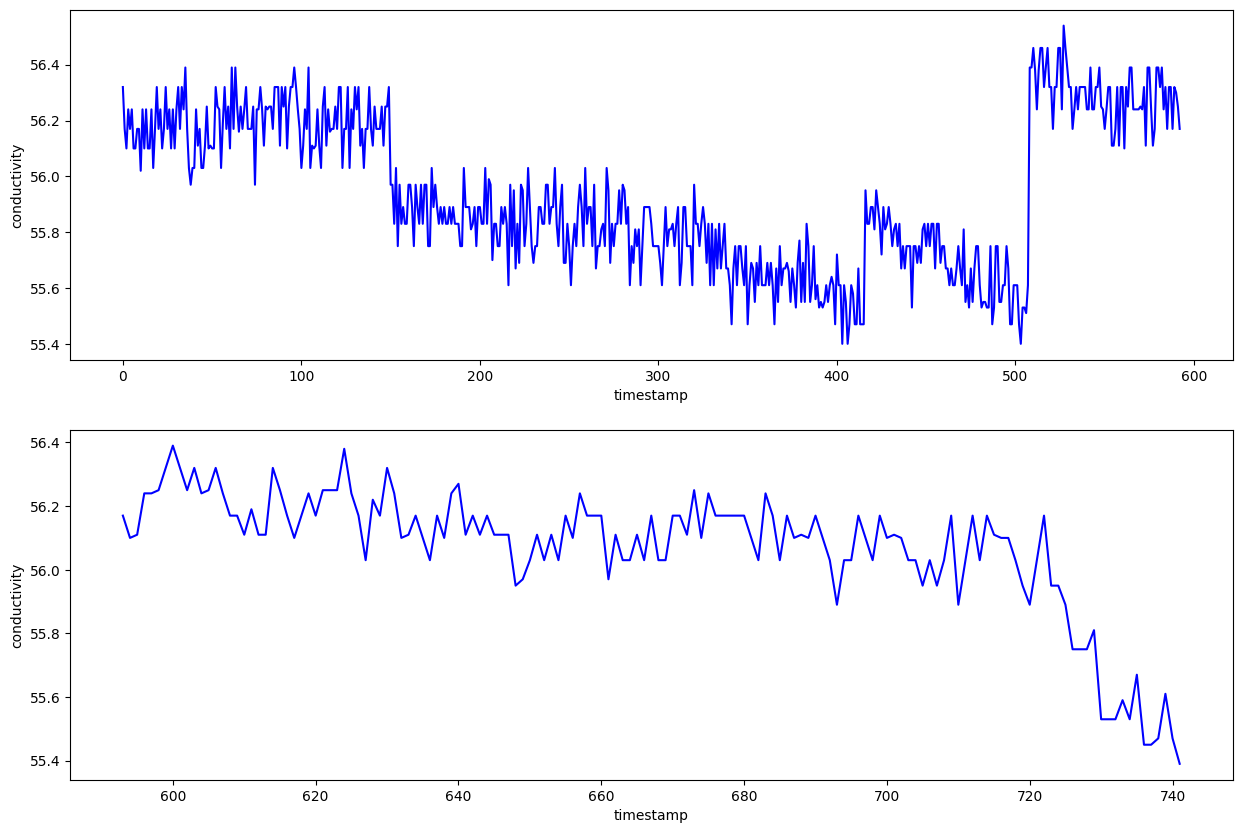

In [27]:
# Data visualization
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax1 = sns.lineplot(data=train, x='timestamp', y='conductivity', color='blue', ax=ax[0])
#ax1 = sns.scatterplot(data=train_anomalies, x='timestamp', y='stand_value', color='red', ax=ax[0])

ax2 = sns.lineplot(data=valid, x='timestamp', y='conductivity', color='blue', ax=ax[1])
#ax2 = sns.scatterplot(data=valid_anomalies, x='timestamp', y='stand_value', color='red', ax=ax[1])
plt.show()

In [30]:
# Function to create sequences remains the same
def create_sequences(data, time_steps):
    X = []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
    return np.array(X)


In [ ]:
# Creating sequences from training data
TIME_STEPS = 30 # Number of past time steps to look at

# Extract `run_id`s
run_id = train_c['run_id'].unique()

X_train = []

# Iterate over each `run_id` to create sequences of data for that run and append to X_train
for rid in run_id:
    idx = train_c[train_c['run_id'] == rid].index
    run_data = train_conduct.iloc[idx, :]['stand_value'].values
    run_sequences = create_sequences(run_data, TIME_STEPS)
    X_train.append(run_sequences)
    
X_train = np.vstack(X_train)
    
# For autoencoder, input = output
Y_train = X_train.copy()

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
Y_train = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)

# Verify the shapes
print(f"Training sequences shape: {X_train.shape}")
print(f"Training labels shape: {Y_train.shape}")

X_train[1]

Training sequences shape: (2840, 30, 1)
Training labels shape: (2840, 30, 1)


array([[1.14070862],
       [0.51363067],
       [0.51363067],
       [0.51363067],
       [0.51363067],
       [0.51363067],
       [0.80626704],
       [0.80626704],
       [0.80626704],
       [0.22099429],
       [0.22099429],
       [0.22099429],
       [0.80626704],
       [0.80626704],
       [0.80626704],
       [0.80626704],
       [0.80626704],
       [0.80626704],
       [0.51363067],
       [0.51363067],
       [0.51363067],
       [0.51363067],
       [0.51363067],
       [0.59724106],
       [0.80626704],
       [0.80626704],
       [0.80626704],
       [0.22099429],
       [0.22099429],
       [0.22099429]])

In [ ]:
TIME_STEPS = 30 # Number of past time steps to look at

# Create sequences from your training data
X_train = create_sequences(train_conduct['stand_value'].values, TIME_STEPS)

# Create sequences from your validation data
X_valid = create_sequences(valid_conduct['stand_value'].values, TIME_STEPS)

# For the autoencoder, the target (y) is the same as the input (X)
y_train = X_train
y_valid = X_valid

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], y_train.shape[1], 1)
X_valid = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)
y_valid = y_valid.reshape(y_valid.shape[0], y_valid.shape[1], 1)

print(f"Training sequences shape: {X_train.shape}")
print(f"Validation sequences shape: {X_valid.shape}")

X_train[1]

Training sequences shape: (1405, 30, 1)
Validation sequences shape: (329, 30, 1)


array([[ 0.39130353],
       [ 0.39130353],
       [ 0.64894085],
       [ 0.39130353],
       [ 0.64894085],
       [ 0.39130353],
       [ 0.39130353],
       [ 0.39130353],
       [ 0.39130353],
       [ 0.39130353],
       [-0.20985024],
       [-0.20985024],
       [-0.20985024],
       [-0.20985024],
       [-0.20985024],
       [ 0.64894085],
       [ 0.64894085],
       [ 0.39130353],
       [-0.16691069],
       [-0.55336668],
       [-0.55336668],
       [-0.55336668],
       [-0.20985024],
       [-0.20985024],
       [ 0.39130353],
       [ 0.39130353],
       [ 0.39130353],
       [-0.20985024],
       [-0.20985024],
       [-0.20985024]])

In [ ]:
# Print dataset lengths
print("raw train rows:", len(train_conduct))
print("raw valid rows:", len(valid_conduct))

# Print sequence shapes (must run after sequence creation)
print("X_train.shape:", X_train.shape)   # expect (n_samples, TIME_STEPS, 1)
print("y_train.shape:", y_train.shape)   # expect same as X_train
print("X_valid.shape:", X_valid.shape)
print("y_valid.shape:", y_valid.shape)

# Check min samples vs batch/validation
n_samples = X_train.shape[0]
print("n_samples:", n_samples)
print("batch_size:", 32)
print("n_samples < batch_size?", n_samples < 32)
print("n_samples * (1 - validation_split) approx:", n_samples * 0.9)

raw train rows: 1435
raw valid rows: 359
X_train.shape: (1405, 30, 1)
y_train.shape: (1405, 30, 1)
X_valid.shape: (329, 30, 1)
y_valid.shape: (329, 30, 1)
n_samples: 1405
batch_size: 32
n_samples < batch_size? False
n_samples * (1 - validation_split) approx: 1264.5


## Model Training

In [67]:
# Define the model architecture
model = Sequential([
    # Encoder
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(rate=0.2),
    
    # This layer repeats the learned representation for each time step
    # so the decoder can reconstruct the original sequence.
    RepeatVector(X_train.shape[1]),
    
    # Decoder
    LSTM(128, return_sequences=True),
    Dropout(rate=0.2),
    
    # The output layer that reconstructs the input
    TimeDistributed(Dense(X_train.shape[2]))
])

model.compile(optimizer='adam', loss='mae')
model.summary()

c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_anomaly_detection-main\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 30, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 30, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    shuffle=False
)

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 66s 47ms/step - loss: 0.3517 - val_loss: 0.3963
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.3377 - val_loss: 0.3420
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.3865 - val_loss: 0.4271
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.4012 - val_loss: 0.4634
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.4487 - val_loss: 0.5917
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.3921 - val_loss: 0.3472
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.3560 - val_loss: 0.4654


In [78]:
# Predict on the training data to get the reconstruction error for "normal" data
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

# Set the anomaly threshold based on the training data's loss distribution
# A common approach is to use a high percentile (e.g., 99th)
threshold = np.quantile(train_mae_loss, 0.99)

print(f"Anomaly threshold set to: {threshold}")

# Create a DataFrame with the train loss
train_loss_df = pd.DataFrame(index=range(len(train_mae_loss)))
train_loss_df['reconstruction_error'] = train_mae_loss

# Identify anomalies in the train set
train_loss_df['anomaly'] = train_loss_df['reconstruction_error'] > threshold

# Find the indices of the anomalous sequences
train_anomalies_idxs = train_loss_df[train_loss_df['anomaly']].index

# Map these sequence indices back to the original validation DataFrame indices
# The anomaly is at the end of the sequence window
anomalous_data_indices = []
for seq_idx in train_anomalies_idxs:
    anomalous_data_indices.append(seq_idx + TIME_STEPS - 1)

# Add an anomaly flag to your original validation DataFrame
# Note: The first `TIME_STEPS` rows of valid_df won't have a prediction
train_conduct['anomaly'] = False
train_conduct.iloc[anomalous_data_indices] = train_conduct.iloc[anomalous_data_indices].assign(anomaly=True)

print("Anomalies found in the validation set:")
print(train_conduct[train_conduct['anomaly']])

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Anomaly threshold set to: 1.0579466949923246
Anomalies found in the validation set:
      timestamp  conductivity  stand_value  anomaly
1202       1202         56.39     2.194765     True
1203       1203         56.39     2.194765     True
1204       1204         56.39     2.194765     True
1205       1205         56.38     2.151825     True
1206       1206         56.39     2.194765     True
1207       1207         56.39     2.194765     True
1208       1208         56.46     2.495342     True
1209       1209         56.46     2.495342     True
1210       1210         56.46     2.495342     True
1211       1211         56.46     2.495342     True
1212       1212         56.54     2.838858     True
1213       1213         56.38     2.151825     True
1214       1214         56.39     2.194765     True
1215       1215         56.39     2.194765     True
1216       1216         56.39     2.194765     True


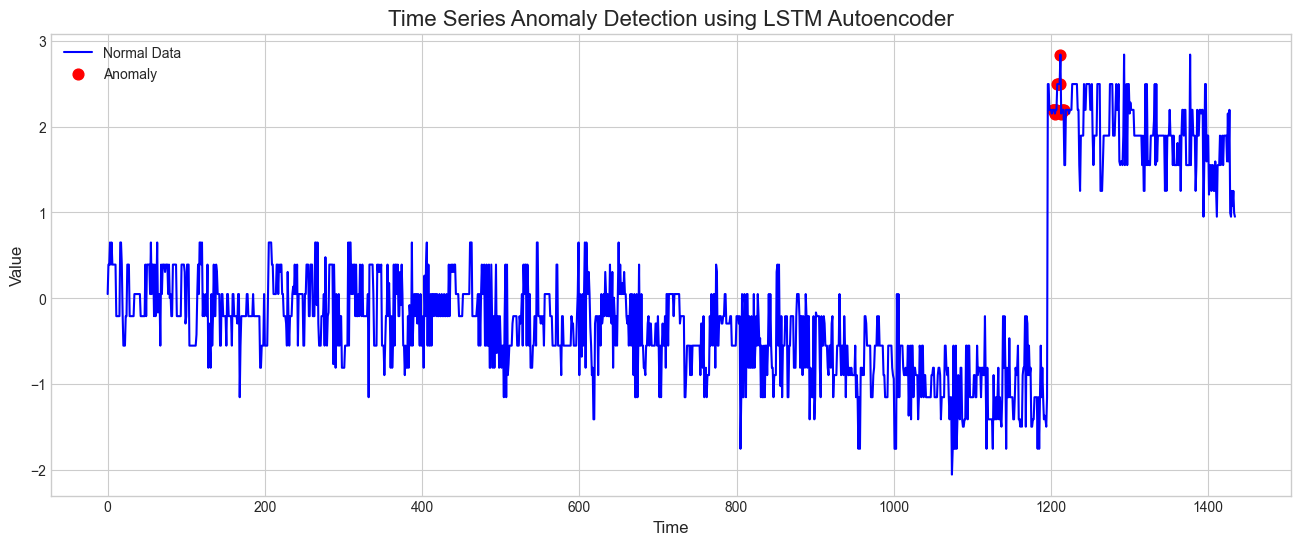

In [79]:
# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 6))

# Plot the original data
ax.plot(train_conduct.index, train_conduct['stand_value'], color='blue', label='Normal Data')

# Highlight the anomalies
anomalies = train_conduct[train_conduct['anomaly'] == True]
ax.scatter(anomalies.index, anomalies['stand_value'], color='red', marker='o', s=60, label='Anomaly')

ax.set_title('Time Series Anomaly Detection using LSTM Autoencoder', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.legend(loc='upper left')
plt.show()

In [84]:
# Predict on the validation data
X_valid_pred = model.predict(X_valid)
valid_mae_loss = np.mean(np.abs(X_valid_pred - X_valid), axis=1).flatten()

# Create a DataFrame with the validation loss
loss_df = pd.DataFrame(index=range(len(valid_mae_loss)))
loss_df['reconstruction_error'] = valid_mae_loss

# Identify anomalies in the validation set
loss_df['anomaly'] = loss_df['reconstruction_error'] > threshold

# Find the indices of the anomalous sequences
valid_anomalies_idxs = loss_df[loss_df['anomaly']].index

# Map these sequence indices back to the original validation DataFrame indices
# The anomaly is at the end of the sequence window
anomalous_data_indices = []
for seq_idx in valid_anomalies_idxs:
    anomalous_data_indices.append(seq_idx + TIME_STEPS - 1)

# Add an anomaly flag to your original validation DataFrame
# Note: The first `TIME_STEPS` rows of valid_df won't have a prediction
valid_conduct['anomaly'] = False
valid_conduct.iloc[anomalous_data_indices] = valid_conduct.iloc[anomalous_data_indices].assign(anomaly=True)

print("Anomalies found in the validation set:")
print(valid_conduct[valid_conduct['anomaly']])

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Anomalies found in the validation set:
Empty DataFrame
Columns: [timestamp, conductivity, stand_value, anomaly]
Index: []


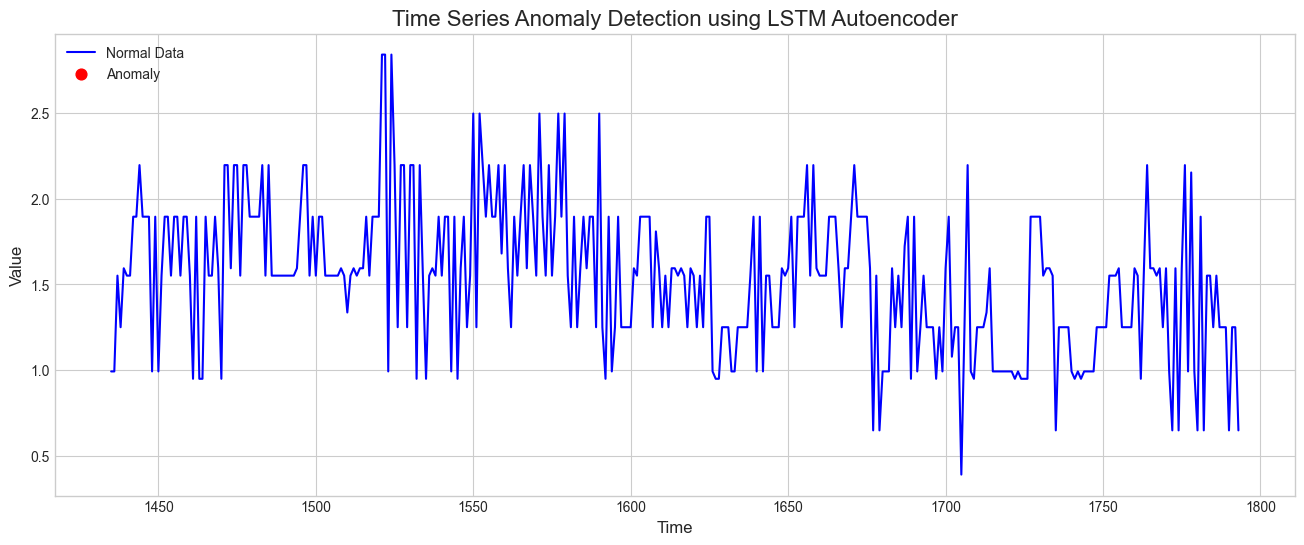

In [85]:
# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 6))

# Plot the original data
ax.plot(valid_conduct.index, valid_conduct['stand_value'], color='blue', label='Normal Data')

# Highlight the anomalies
anomalies = valid_conduct[valid_conduct['anomaly'] == True]
ax.scatter(anomalies.index, anomalies['stand_value'], color='red', marker='o', s=60, label='Anomaly')

ax.set_title('Time Series Anomaly Detection using LSTM Autoencoder', fontsize=16)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.legend(loc='upper left')
plt.show()

## Confusion metrics

In [81]:
# except confusion matrix
from sklearn.metrics import precision_recall_fscore_support

def calculate_metrics(
    ground_truth: pd.DataFrame, anomalies_idxs: list
    ):
    predictions = pd.DataFrame(
        index=range(len(ground_truth)), 
        columns=['anomaly_predicted']
    )
    predictions['anomaly_predicted'] = 0
    predictions.iloc[anomalies_idxs] = 1
    
    # Calculation of the confusion matrix can be done using pandas
    confusion_matrix = pd.crosstab(
        ground_truth.loc[:, 'anomaly_label'],
        predictions['anomaly_predicted'], 
        margins=True
    )
    precision, recall, f1, _ = precision_recall_fscore_support(
        ground_truth.loc[:, 'anomaly_label'],
        predictions['anomaly_predicted'], 
        beta=2., 
        average='binary'
    )
    return confusion_matrix, precision, recall, f1

In [83]:
train_conduct['anomaly_label'] = 0

train_conf_matrix, *train_metrics = calculate_metrics(
    train_conduct, train_anomalies_idxs
)

# Pretty printing of the metrics
print(f'Train:\n Precision: {train_metrics[0]:.3f}\n' 
      f'Recall: {train_metrics[1]:.3f}\n' 
      f'F2 score: {train_metrics[2]:.3f}')

Train:
 Precision: 0.000
Recall: 0.000
F2 score: 0.000


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_anomaly_detection-main\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [86]:
valid_conduct['anomaly_label'] = 0

valid_conf_matrix, *valid_metrics = calculate_metrics(
    valid_conduct, valid_anomalies_idxs
)

print(f'Valid:\n Precision: {valid_metrics[0]:.3f}\n' 
      f'Recall: {valid_metrics[1]:.3f}\n' 
      f'F2 score: {valid_metrics[2]:.3f}')

Valid:
 Precision: 0.000
Recall: 0.000
F2 score: 0.000


c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_anomaly_detection-main\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_anomaly_detection-main\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\kittyoomm\Desktop\Work@MTEC\PlateMon_anomaly_detection-main\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to con

## Test